<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic11/Chollet_HFST11c_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

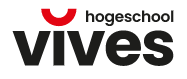<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



# 11. Deep learning for text: Transformers

Deze notebook bevat de codevoorbeelden (met aanvullende uitleg) uit het derde deel van hoofdstuk 11 van het boek "Deep Learning with Python" (2e editie) van François Chollet, nl. paragrafen 11.4 en 11.5 over transformers.

## 11.4. The Transformer architecture

Deze twee YouTube video's leggen uit hoe de Transformer is opgebouwd:
- https://youtu.be/_UVfwBqcnbM
- https://youtu.be/S27pHKBEp30




### Understanding self-attention

De originele Transformer [paper](https://arxiv.org/abs/1706.03762) heeft als titel: "Attention Is All You Need". Dat is omdat een simpel mechanisme - **neural attention** - kan toegepast worden om sequence models te bouwen die geen gebruik maken van convolutionele of recurrente layers!

De figuur hieronder illustreert het principe: adhv attention scores wordt bepaald welke features relevanter zijn dan andere. Dat is zoals ook wij onze aandacht focussen op zaken die we belangrijk vinden. En eerder hebben we al een gelijkaardige mechanisme besproken, nl. de max-pooling techniek die de pixel met de hoogste waarde selecteert en de andere negeert.

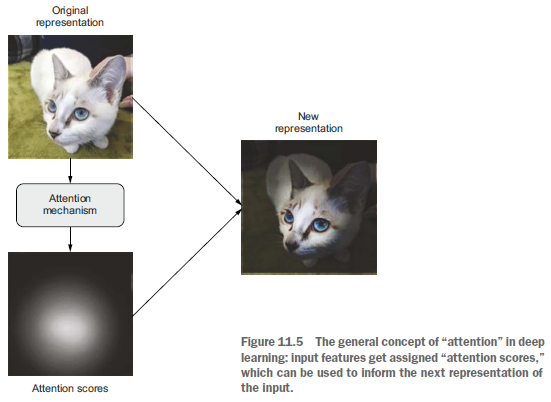

Het attention mechanisme kan ook gebruikt worden om features 'bewust' te maken van de context, in het Engels **context-awareness**. En bij tekstdata is dat belangrijk, want de betekenis van woorden is afhankelijk van de context!

We hebben al gezien hoe word embeddings werken en die contextafhankelijkheid betekent hier dus dat de vector die een woord in een zin voorstelt, afhangt van de andere woorden in die zin. En dat is waar **self-attention** om de hoek komt kijken: *The purpose of self-attention is to modulate the representation of a token
by using the representations of related tokens in the sequence. This produces context-aware
token representations.*

Het principe van self-attention wordt hieronder voorgesteld voor het woord 'station' dat inderdaad verschillende betekenissen kan hebben: radio station, train station, space station, ... Door de context weten we echter dat het om een treinstation gaat en we zien dat de 'attention score' voor 'train' inderdaad hoger is dan voor de andere woorden.

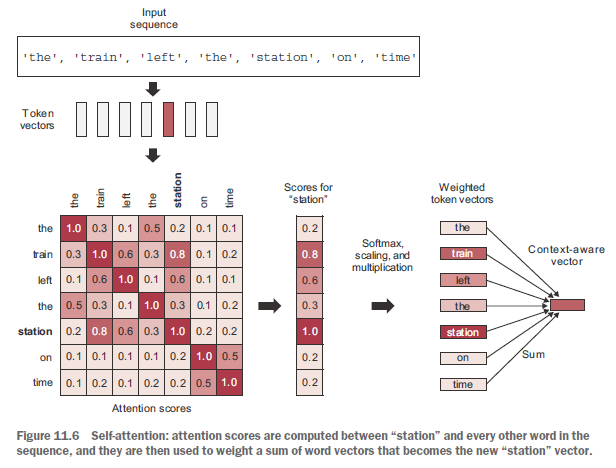

De attention scores worden herschaald en getransformeerd mbv de softmax-functie, en tenslotte met de originele word embedding vector van het woord vermenigvuldigd om een nieuwe vector te krijgen die dus rekening houdt met de aanwezigheid van de andere woorden in de zin. Uiteraard moet dit uitgevoerd worden voor elk woord in de zin. In Python zouden we zoiets kunnen schrijven:

```python
def self_attention(input_sequence):
    output = np.zeros(shape=input_sequence.shape)
    for i, pivot_vector in enumerate(input_sequence):
        scores = np.zeros(shape=(len(input_sequence),))
        for j, vector in enumerate(input_sequence):
            scores[j] = np.dot(pivot_vector, vector.T)
        scores /= np.sqrt(input_sequence.shape[1])
        scores = softmax(scores)
        new_pivot_representation = np.zeros(shape=pivot_vector.shape)
        for j, vector in enumerate(input_sequence):
            new_pivot_representation += vector * scores[j]
        output[i] = new_pivot_representation
    return output
```

De score van twee woorden wordt bepaald door eenvoudigweg het inwendig product van de twee overeenkomstige vectoren uit de embedding space te berekenen. In Keras is dat de `MultiHeadAttention` layer die dat voor zijn rekening neemt:

```python
num_heads = 4
embed_dim = 256
mha_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
outputs = mha_layer(inputs, inputs, inputs)
```

Maar wat zijn die 'multi heads'? En waarom wordt `inputs` 3x doorgegeven?


### Generalized self-attention: the query-key-value model

Het antwoord op de tweede vraag - waarom 3x dezelfde `inputs` - is: **query-key-value**. Dit zijn termen die komen uit de wereld van de search engines en de recommender systems.

 Samengevat doet het self-attention mechanisme het volgende:

> `outputs = sum(inputs * pairwise_scores(inputs, inputs))`

De `inputs` worden dus 3x gebruikt. Maar het is niet zo dat het altijd om 3x dezelfde vectoren moet gaan. Meer algemeen kunnen we schrijven:

> `outputs = sum(values * pairwise_scores(query, keys))`

Dat leest als *“for each element in the query, compute how much the element is related to every key, and use these scores to weight a sum of values”*.

*Conceptually, this is what Transformer-style attention is doing. You’ve got a reference
sequence that describes something you’re looking for: the query. You’ve got a
body of knowledge that you’re trying to extract information from: the values. Each
value is assigned a key that describes the value in a format that can be readily compared
to a query. You simply match the query to the keys. Then you return a weighted
sum of values.*

De figuur hieronder stelt het grafisch voor:

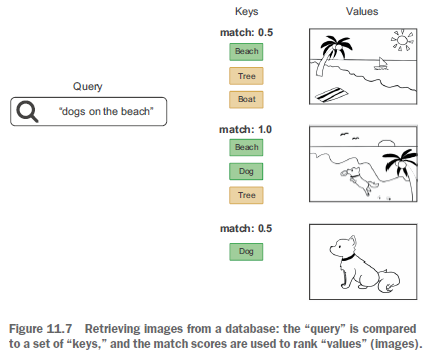

Bij tekstclassificatie zijn query, keys en values hetzelfde, maar bij machine translation is dat niet zo, want de 'query' is hier de 'target' (of de vertaalde zinnen), en 'keys' en 'values' zijn de 'source' (of de te vertalen zinnen).

### Multi-head attention

Het antwoord op de vraag wat die 'multi heads' zijn wordt weergegeven op de figuur hieronder. Het query-key-value model wordt meerdere keren naast elkaar toegepast in verschillende 'heads'. Dat is een gelijkaardig mechanisme zoals dat van de depthwise separable convolutions:

*The output space of the self-attention layer gets factored into a set of independent subspaces, learned separately: the initial query, key, and value are sent through three
independent sets of dense projections, resulting in three separate vectors. Each vector
is processed via neural attention, and the different outputs are concatenated back
together into a single output sequence. Each such subspace is called a “head.”*

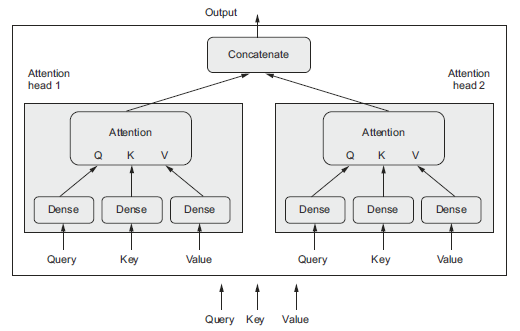

### The Transformer encoder

Voor sequence-to-sequence problemen zoals machine translation hebben we een Transformer encoder en decoder nodig. Voor tekstclassificatie volstaat de encoder. Hoe die is opgebouwd zie je hieronder:

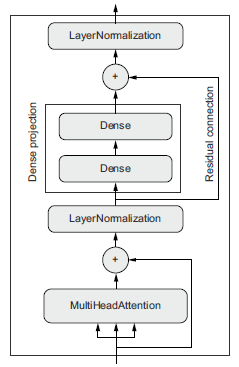

We zien de `MultiHeadAttention` layer die opgevolgd wordt door 2 `Dense` layers waar we mee vertrouwd zijn. Wat we ook kennen zijn de *residual connections* die toegevoegd worden om ervoor te zorgen dat er geen waardevolle informatie wordt vernietigd door al die opeenvolgende transformaties.

Tenslotte zien we ook dat er `LayerNormalization` wordt toegepast, wat gelijkaardig is aan de `BatchNormalization` die we eerder hebben gezien. Die laatste werkt echter niet zo goed bij sequentiële data omdat die standaardiseert obv de volledige batch. Wanneer we echter de reeksen afzonderlijk standaardiseren, dan werkt het wel:

```python
def layer_normalization(batch_of_sequences):
    mean = np.mean(batch_of_sequences, keepdims=True, axis=-1)
    variance = np.var(batch_of_sequences, keepdims=True, axis=-1)
    return (batch_of_sequences - mean) / variance
```
We zien dus dat de `LayerNormalization` zowel bij het berekenen van `mean` en `variance` enkel de laatste dimensie (`axis=-1`) neemt, en dat is de dimensie van de 'embedding'. Bij `BatchNormalization` worden gemiddelde en variantie berekend obv alle elementen in alle dimensies (`axis=(0,1,2)`).

Laten we die Transformer encoder nu eens implementeren in Keras door overerving toe te passen op klasse `Layer`:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

class TransformerEncoder(layers.Layer):

    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim  # size of the input token vectors
        self.dense_dim = dense_dim  # size of the inner dense layers
        self.num_heads = num_heads  # number of attention heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):  # computation goes in call()
        if mask is not None:
            mask = mask[:, tf.newaxis, :]  # embedding mask is 2D, but attention layer expects 3D
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):  # implement serialization so we can save the model
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

Bemerk dat de `get_config` methode wordt overschreven zodat het model kan opgeslagen worden via [serialization](https://en.wikipedia.org/wiki/Serialization). (Zie boek pag 344 voor meer info.)

We kunnen de klasse `TransformerEncoder` nu toepassen in een model voor tekstclassificatie:

In [ ]:
vocab_size = 20_000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
# Since TransformerEncoder returns full sequences, we need to reduce each sequence
# to a single vector for classification via a global pooling layer.
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

Bemerk dat we hier de word embedding laten afleiden door het model zelf ipv gebruik te maken van een pretrained word embedding, en dat de `TransformerEncoder` wordt gevolgd door een `GlobalMaxPooling1D` layer om de output van de encoder te reduceren zodat de laatste `Dense` layer ermee aan de slag kan om de output van het model te berekenen.

We kunnen dat model nu trainen op onze IMDB dataset, die we natuurlijk eerst moeten downloaden, opsplitsen en vectoriseren:

In [ ]:
# getting the data
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  8963k      0  0:00:09  0:00:09 --:--:-- 16.3M


In [ ]:
# preparing the data
import os, pathlib, shutil, random

batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [ ]:
# vectorizing the data

max_length = 600
max_tokens = 20_000  # vocab_size
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Het model trainen en evalueren:

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
625/625 [==============================] - 49s 69ms/step - loss: 0.4879 - accuracy: 0.7707 - val_loss: 0.3326 - val_accuracy: 0.8540
Epoch 2/20
625/625 [==============================] - 43s 68ms/step - loss: 0.3103 - accuracy: 0.8698 - val_loss: 0.3399 - val_accuracy: 0.8548
Epoch 3/20
625/625 [==============================] - 42s 67ms/step - loss: 0.2426 - accuracy: 0.9018 - val_loss: 0.2926 - val_accuracy: 0.8784
Epoch 4/20
625/625 [==============================] - 42s 67ms/step - loss: 0.1866 - accuracy: 0.9278 - val_loss: 0.3432 - val_accuracy: 0.8732
Epoch 5/20
625/625 [==============================] - 42s 67ms/step - loss: 0.1520 - accuracy: 0.9423 - val_loss: 0.3962 - val_accuracy: 0.8654
Epoch 6/20
625/625 [==============================] - 42s 67ms/step - loss: 0.1262 - accuracy: 0.9524 - val_loss: 0.3338 - val_accuracy: 0.8682
Epoch 7/20
625/625 [==============================] - 42s 67ms/step - loss: 0.1033 - accuracy: 0.9611 - val_loss: 0.5509 - val_accuracy:

In [ ]:
import matplotlib.pyplot as plt

def plot_result(history):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='training');
    ax1.plot(history.history['val_loss'], label='validation');
    ax1.set_title('loss');
    ax1.legend();
    ax1.grid();
    ax2.plot(history.history['accuracy'], label='training');
    ax2.plot(history.history['val_accuracy'], label='validation');
    ax2.set_title('accuracy');
    ax2.legend();
    ax2.grid();

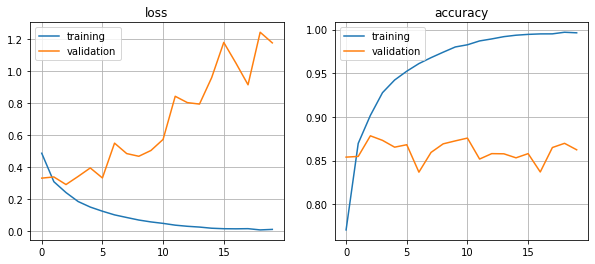

In [ ]:
plot_result(history)

Het model dat we net hebben getraind doet het niet beter dan het bidirectioneel LSTM model dat we eerder hebben opgesteld! De reden? Het is geen sequence model want het houdt geen rekening met de woordvolgorde!

Inderdaad, het mechanisme van de self-attention bekijkt enkel woordparen maar houdt geen rekening met de positie van de woorden in de zin. In theorie zouden we de woorden van de reviews kunnen shuffelen en dat zou de zelfde attention scores opleveren en dus een even performant model. Dus wat missen we hier? Positional encoding!


### Using positional encoding to re-inject order information

De echte Transformer bevat dus ook nog een laag die de woordvolgorde codeert! Op die manier gaan onze input word embeddings 2 componenten hebben: de gewone woordvector en een positievector.

De figuur hieronder vat mooi samen in hoeverre de verschillende NLP modellen die we hebben besproken de woordvolgorde en de context van de woorden in rekening brengen:


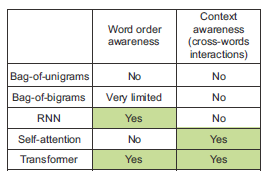

Naast de vector die elk woord weergeeft, hebben we dus ook nog een positievector van het woord nodig. We zouden eenvoudigweg de index van het woord in de zin kunnen toevoegen aan de embedding vector, maar omdat die index een zeer groot getal kan zijn, is dat niet aangewezen.

In de originele Transformers paper past men een transformatie toe o.b.v. de cosinusfunctie die de unieke positie van een woord uitdrukt als een getal tussen -1 en 1. [Deze blog](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/) legt uit hoe die **positional encoding** in zijn werk gaat.

Maar we kunnen ook iets eenvoudiger en effectiever doen, nl. **positional embedding** toepassen: *We’ll learn position embedding
vectors the same way we learn to embed word indices. We’ll then proceed
to add our position embeddings to the corresponding word embeddings, to obtain a
position-aware word embedding.*

Laten we een `PositionalEmbedding` layer implementeren als subklasse van Keras klasse `Layer`:

In [ ]:
class PositionalEmbedding(layers.Layer):

    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        # Prepare an Embedding layer for the token indices
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        # Prepare an Embedding layer for the token positions
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):  # computation goes in call()
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions  # add both embedding vectors together

    # Like the Embedding layer, this layer should be able to generate a mask
    # so we can ignore padding 0s in the inputs.
    # The compute_mask method will be called automatically by the framework,
    # and the mask will get propagated to the next layer.
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):  # implement serialization so we can save the model
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

We kunnen de positional embedding layer nu toevoegen aan onze Transformer encoder:

In [ ]:
vocab_size = 20_000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
# PositionalEmbedding ipv Embedding!
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding_1 (Pos  (None, None, 256)        5273600   
 itionalEmbedding)                                               
                                                                 
 transformer_encoder_2 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                           

Het model trainen en evalueren:

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
625/625 [==============================] - 46s 70ms/step - loss: 0.4609 - accuracy: 0.7879 - val_loss: 0.2829 - val_accuracy: 0.8868
Epoch 2/20
625/625 [==============================] - 42s 67ms/step - loss: 0.2272 - accuracy: 0.9118 - val_loss: 0.2643 - val_accuracy: 0.8930
Epoch 3/20
625/625 [==============================] - 42s 68ms/step - loss: 0.1714 - accuracy: 0.9355 - val_loss: 0.2885 - val_accuracy: 0.8890
Epoch 4/20
625/625 [==============================] - 43s 69ms/step - loss: 0.1430 - accuracy: 0.9474 - val_loss: 0.2886 - val_accuracy: 0.8856
Epoch 5/20
625/625 [==============================] - 43s 68ms/step - loss: 0.1222 - accuracy: 0.9549 - val_loss: 0.3692 - val_accuracy: 0.8754
Epoch 6/20
625/625 [==============================] - 43s 68ms/step - loss: 0.1073 - accuracy: 0.9610 - val_loss: 0.3764 - val_accuracy: 0.8762
Epoch 7/20
625/625 [==============================] - 43s 68ms/step - loss: 0.0953 - accuracy: 0.9667 - val_loss: 0.3673 - val_accuracy:

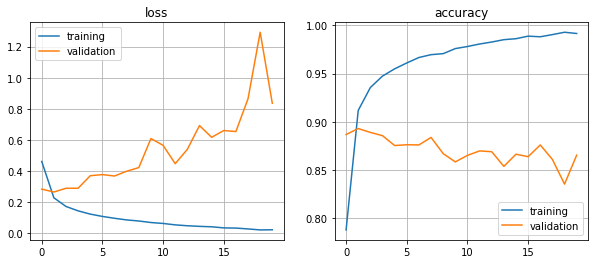

In [ ]:
plot_result(history)

Dat is zeker een verbetering tov het model zonder de positional encoding, maar niet echt tov het bidirectionele RNN. En het bag-of-bigrams model deed het zelfs beter! Dus stelt zich de vraag wanneer we welk model best gebruiken?

### When to use sequence models over bag-of-words models?

Bag-of-words models zijn dus zeker nog altijd nuttig! Meer nog, in het geval van tekstclassificatie zijn ze de meest aangewezen benadering wanneer de dataset relatief klein is en samples bevat met relatief veel woorden. Heb je echter een dataset met relatief veel samples die relatief weinig woorden bevatten, dan zijn sequence models waarschijnlijk de beste keuze, omdat de korte reeksen weinig informatie bevatten en je dus beter niks weggooit.

Een eenvoudige vuistregel is de volgende:

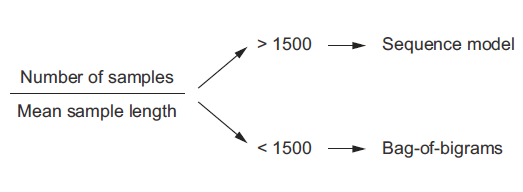

Moet je documenten classificeren die gemiddeld 1000 woorden lang zijn en je dataset bestaat uit 100 000 documenten, dan neem je best een bag-of-words model, want de ratio is 100. Heb je echter 500 000 tweets van gemiddeld 40 woorden lang, dan is de ratio 12 500, en dan neem je beter een sequence model. De IMDB dataset bevat 20 000 samples van gemiddeld 233 woorden, dus ook hier klopt de vuistregel, want de bag-of-bigrams model was het meest performant. Bovendien vergen bag-of-words models minder rekentijd!

Let wel op dat de vuistregel enkel voor tekstclassificatie geldt en niet voor andere NLP taken. Bij machine translation bijv. blinken transformers uit! Laten we dat eens bekijken.

## 11.5. Beyond text classification: Sequence-to-sequence learning

Sequence-to-sequence models zijn modellen die een sequentie als input krijgen en een andere sequentie als output teruggeven. NLP taken die gebruik maken van dergelijke modellen zijn:

- **Machine translation**: *Convert a paragraph in a source language to its equivalent
in a target language.*
- **Text summarization**: *Convert a long document to a shorter version that retains
the most important information.*
- **Question answering**: *Convert an input question into its answer.*
- **Chatbots**: *Convert a dialogue prompt into a reply to this prompt, or convert the
history of a conversation into the next reply in the conversation.*
- **Text generation**: *Convert a text prompt into a paragraph that completes the prompt.*
- ...

Sequence-to-sequence modellen bestaan uit een **encoder** en een **decoder**:

*During training:*
- *An encoder model turns the source sequence into an intermediate representation.*
- *A decoder is trained to predict the next token i in the target sequence by looking
at both previous tokens (0 to i - 1) and the encoded source sequence.*

*During inference, we don’t have access to the target sequence — we’re trying to predict
it from scratch. We’ll have to generate it one token at a time:*

1. *We obtain the encoded source sequence from the encoder.*
2. *The decoder starts by looking at the encoded source sequence as well as an initial
“seed” token (such as the string `"[start]"`), and uses them to predict the
first real token in the sequence.*
3. *The predicted sequence so far is fed back into the decoder, which generates the
next token, and so on, until it generates a stop token (such as the string `"[end]"`).*

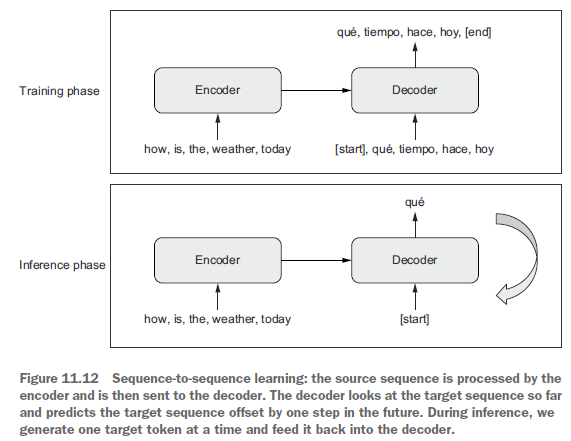

### A machine translation example

Transformers zijn origineel ontwikkeld voor machine translation! We nemen daarom een voorbeeld van vertalen van Engels naar Spaans. We downloaden een geschikte dataset:

In [1]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2023-12-07 14:03:56--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.207, 173.194.196.207, 173.194.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.03s   

2023-12-07 14:03:56 (74.0 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



De tekstfile bevat een example per lijn en elk voorbeeld bestaat uit de zin in het Engels gevolgd door de vertaling in het Spaans:

In [2]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"  # add [start] and [end] token to spanish sentence
    text_pairs.append((english, spanish))

Checken hoe zo'n example eruit ziet:

In [ ]:
import random
print(random.choice(text_pairs))

('Tom is madly in love with Mary.', '[start] Tom está locamente enamorado de Mary. [end]')


Bemerk de `'[start]'` en `'[end]'` tokens aan het begin en op het einde van de Spaanse zin.

Uiteraard splitsen we de dataset op in een training-, validatie- en testset:

In [3]:
import random
random.shuffle(text_pairs)  # shuffelen
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]  # 70% training
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]  # 15% validatie
test_pairs = text_pairs[num_train_samples + num_val_samples:]  # 15% testing

We moeten nu zowel de Engelse als de Spaanse zinnen *vectoriseren*. In beide gevallen verwijderen we de leestekens. Bij de spaanse zinnen moeten we ook rekening houden met het omgekeerde vraagteken `"¿"`. Maar we mogen niet de vierkante haakjes verwijderen omdat die deel uitmaken van de start- en end-tokens. (In real-world toepassingen gaan we de leestekens als aparte tokens beschouwen ipv ze te verwijderen omdat we willen dat ze deel uitmaken van de vertaling.)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import string
import re

strip_chars = string.punctuation + "¿"  # omgekeerd vraagten toevoegen
strip_chars = strip_chars.replace("[", "")  # vierkante haakjes niet verwijderen
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)  # naar lower case omzetten
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15_000  # max aantal tokens
sequence_length = 20  # max lengte van de sequences

source_vectorization = layers.TextVectorization(  # Engels
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(  # Spaans
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_english_texts = [pair[0] for pair in train_pairs]  # Engels
train_spanish_texts = [pair[1] for pair in train_pairs]  # Spaans

source_vectorization.adapt(train_english_texts)  # Engels
target_vectorization.adapt(train_spanish_texts)  # Spaans

De vectors moeten nu natuurlijk nog omgezet worden naar input voor het neuraal netwerk. Daarvoor gebruiken we een `tf.data` pipeline die een tuple `(inputs, targets)` moet retourneren waarbij `inputs` een dictionary is met keys `'english'` en `'spanish'`. De `targets` bestaan uit de Spaanse zinnen die één woord zijn verschoven, zoals we hierboven hebben uitgelegd.

In [5]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({"english": eng,
             "spanish": spa[:, :-1]}, # inputs dict
            spa[:, 1:])  # target is offset by one step ahead!
def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

De shape checken van batches en targets:

In [6]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


Een voorbeeld:

In [16]:
for inputs, targets in train_ds.take(1):
    print(inputs["english"].numpy()[-1])
    print(inputs["spanish"].numpy()[-1])
    print(targets.numpy()[-1])

[ 21 435   4   2 693 339   7 249   0   0   0   0   0   0   0   0   0   0
   0   0]
[  2  27 117  34 775  18  68   6   9 176   3   0   0   0   0   0   0   0
   0   0]
[ 27 117  34 775  18  68   6   9 176   3   0   0   0   0   0   0   0   0
   0   0]


We zien inderdaad dat de elementen in de target één verschoven zijn...

We zijn nu klaar om een model te trainen. We starten met een RNN en dan passen we een Transformer toe.

### Sequence-to-sequence learning with RNNs

Voor de komst van de Transformers waren bidirectionele RNNs de state-of-the-art modellen op vlak van machine translation. Google Translate bijv gebruikte in 2017 een model bestaande uit 7 grote LSTM layers!

Een naïeve implementatie is de volgende waarbij de inputreeks wordt omgezet naar een outputreeks:

```python
inputs = keras.Input(shape=(sequence_length,), dtype="int64")
x = layers.Embedding(input_dim=vocab_size, output_dim=128)(inputs)
x = layers.LSTM(32, return_sequences=True)(x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model(inputs, outputs)
```

Deze benadering is problematisch omdat:
1. input en output reeksen even lang moeten zijn (wat wel met padding kan opgelost worden maar dat is niet ideaal)
2. woord N voorspeld wordt adhv van de N-1 vorige woorden, net zoals bij tijdreeksen.

Om dat op te lossen wordt gebruik gemaakt van een RNN encoder en een RNN decoder!

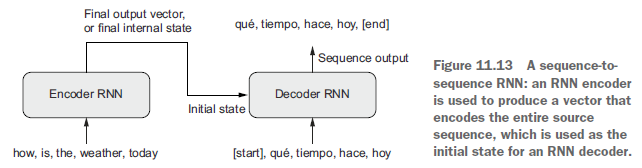

Laten we dat implementeren in Keras. Eerst de encoder:

In [ ]:
from tensorflow import keras
from keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")  # input zijn de Engelse zinnen
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(layers.GRU(latent_dim), merge_mode="sum")(x)

We hebben hier gebruik gemaakt van een bidirectional GRU ipv LSTM omdat de GRU layer eenvoudiger is. De decoder ziet er dan zo uit:

In [ ]:
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")  # input zijn de Spaanse zinnen
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)  # encoder wordt als initial state gebruikt van decoder
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

De decoder krijgt de volledige reeks als input, maar kijkt toch maar naar de eerste N woorden om woord N+1 te voorspellen dankzij de recurrente aard van het model. Op die manier wordt de toekomst voorspeld adhv het verleden zoals het hoort!

Het recurrent sequence-to-sequence model trainen:

In [ ]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
1302/1302 [==============================] - 142s 92ms/step - loss: 1.6387 - accuracy: 0.4167 - val_loss: 1.3229 - val_accuracy: 0.5051
Epoch 2/15
1302/1302 [==============================] - 121s 93ms/step - loss: 1.3121 - accuracy: 0.5284 - val_loss: 1.1589 - val_accuracy: 0.5673
Epoch 3/15
1302/1302 [==============================] - 121s 93ms/step - loss: 1.1672 - accuracy: 0.5784 - val_loss: 1.0749 - val_accuracy: 0.6010
Epoch 4/15
1302/1302 [==============================] - 119s 91ms/step - loss: 1.0777 - accuracy: 0.6099 - val_loss: 1.0507 - val_accuracy: 0.6153
Epoch 5/15
1302/1302 [==============================] - 122s 94ms/step - loss: 1.0292 - accuracy: 0.6355 - val_loss: 1.0325 - val_accuracy: 0.6271
Epoch 6/15
1302/1302 [==============================] - 119s 91ms/step - loss: 0.9989 - accuracy: 0.6536 - val_loss: 1.0264 - val_accuracy: 0.6334
Epoch 7/15
1302/1302 [==============================] - 117s 89ms/step - loss: 0.9791 - accuracy: 0.6679 - val_loss: 1

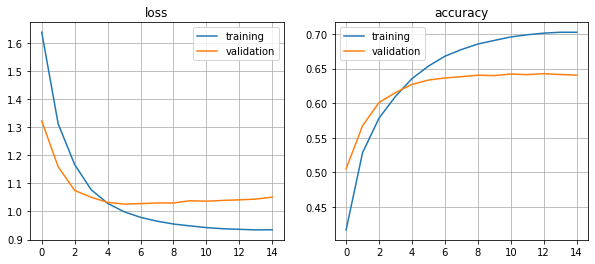

In [ ]:
plot_result(history)

We krijgen bijna 65% nauwkeurigheid bij de validatie, wat wil zeggen dat het Spaanse woord bijna 2 op 3 keer juist wordt voorspeld. Maar nauwkeurigheid is in dit geval niet zo'n goeie evaluatiemetriek:

*Next-token accuracy isn’t a great metric for machine translation models, in particular because it makes the assumption that the correct target tokens from 0 to N are already known when predicting token N+1. In reality, during inference, you’re generating the target sentence from scratch, and you can’t rely on previously generated tokens being 100% correct.
If you work on a real-world machine translation system, you will likely use [BLEU](https://medium.com/nlplanet/two-minutes-nlp-learn-the-bleu-metric-by-examples-df015ca73a86)
scores to evaluate your models — a metric that looks at entire generated sequences
and that seems to correlate well with human perception of translation quality.*

Met onderstaande code kunnen we tenslotte Engelse zinnen vertalen naar het Spaans. Hiervoor gebruiken we de testset:

*We’ll start from the seed token, `"[start]"`,
and feed it into the decoder model, together with the encoded English source sentence.
We’ll retrieve a next-token prediction, and we’ll re-inject it into the decoder
repeatedly, sampling one new target token at each iteration, until we get to `"[end]"`
or reach the maximum sentence length.*

In [ ]:
import numpy as np

# Prepare a dict to convert token index predictions to string tokens.
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"  # seed token
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        # sample the next token
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence],
            verbose=0)  # no printing
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        # Convert the next token prediction to a string and append it to the generated sentence.
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        # Exit condition: either hit max length or sample a stop character
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
This spoon is for tea.
[start] esta es de té [end]
-
"Where have you been?" "I've been to the barber's."
[start] dónde he estado en el [UNK] [end]
-
Did you speak with him about your projects?
[start] le has con acerca de tu acerca de los [UNK] [end]
-
It's just not fair.
[start] es solo no [end]
-
The point is that they are hungry.
[start] el a quién es el hambre [end]
-
I have to write a letter.
[start] tengo que una carta una carta [end]
-
He is acquainted with the modern history of France.
[start] Él está [UNK] de la historia de japón [end]
-
My clock seems to be broken.
[start] mi reloj se parece que está fuera [end]
-
Tom worked there.
[start] tom ahí ahí [end]
-
Let's watch TV.
[start] [UNK] la televisión [end]
-
She hit me, not him.
[start] ella me [UNK] no [end]
-
Don't lecture me.
[start] no me [UNK] [end]
-
Don't be deceived by appearances.
[start] no te por la tarde [end]
-
I bought the car.
[start] compré el coche [end]
-
Lincoln set the slaves free.
[start] [UNK] la los

Ons model doet het niet slecht voor een 'toy model', maar maakt toch nog veel foutjes.

Bemerk ook dat de inferentie stap die we hier hebben geïmplemeneerd niet echt efficiënt is omdat we recursief te werk gaan:

*We reprocess the entire source sentence and the entire generated target sentence every time
we sample a new word. In a practical application, you’d factor the encoder and the
decoder as two separate models, and your decoder would only run a single step at
each token-sampling iteration, reusing its previous internal state.*

Aan het model zelf zouden we natuurlijk ook nog verbeteringen kunnen aanbrengen (zoals LSTM gebruiken ipv GRU), maar RNNs hebben toch fundamentele beperkingen. Zo blijkt bijv dat ze niet goed zijn in het verwerken van zeer lange reeksen. Vandaar dat vandaag de dag de Transformers de state of the art zijn!

### Sequence-to-sequence learning with Transformer

Transformers zijn wel goed in het vertalen van zeer lange documenten doordat ze gebruik maken van het **neural attention** mechanisme. Dat hebben we al uitvoerig besproken en geïmplementeerd in de Transformer encoder. Bij sequence-to-sequence learning hebben we natuurlijk nog een Transformer decoder nodig. De figuur hieronder geeft de volledige architectuur weer van zo'n 'end-to-end' Transformer:

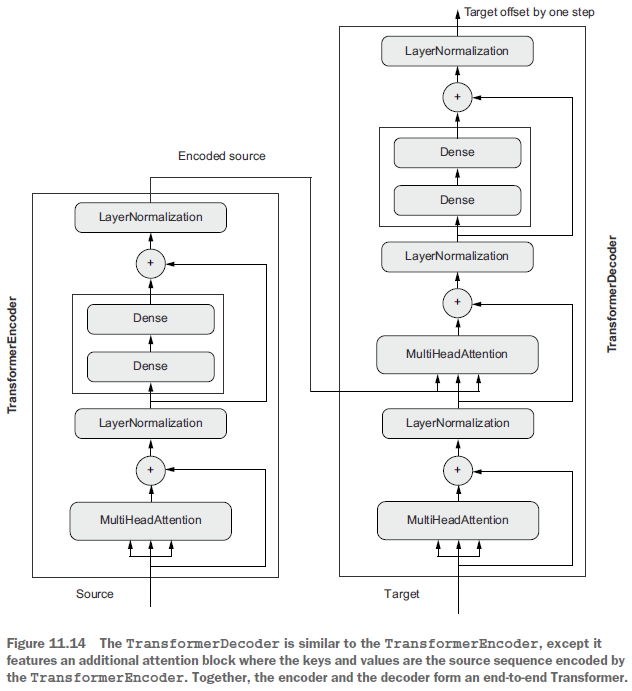

Hieronder zie je de code van de **Transformer decoder** die is geïmplementeerd als subklasse van de Keras `Layer` klasse:

In [ ]:
class TransformerDecoder(layers.Layer):

    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

De **causal attention mask** is nieuw en zorgt ervoor dat de decoder enkel kijkt naar het verleden en niet naar de toekomst. Dat is nodig omdat de decoder de volledige input krijgt (onder de vorm van attention matrices).

Nu hebben we alle bouwstenen om de end-to-end Transformer te implementeren. Er kunnen verschillende encoder eenheden op elkaar geplaatst worden, net als decoder eenheden, maar we beperken ons hier tot één van elk.

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

The sequence-to-sequence Transformer trainen:

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
1302/1302 [==============================] - 95s 70ms/step - loss: 1.6556 - accuracy: 0.4253 - val_loss: 1.2973 - val_accuracy: 0.5183
Epoch 2/30
1302/1302 [==============================] - 93s 71ms/step - loss: 1.3214 - accuracy: 0.5394 - val_loss: 1.1526 - val_accuracy: 0.5741
Epoch 3/30
1302/1302 [==============================] - 92s 71ms/step - loss: 1.1709 - accuracy: 0.5883 - val_loss: 1.0752 - val_accuracy: 0.6047
Epoch 4/30
1302/1302 [==============================] - 92s 71ms/step - loss: 1.0845 - accuracy: 0.6192 - val_loss: 1.0507 - val_accuracy: 0.6231
Epoch 5/30
1302/1302 [==============================] - 91s 70ms/step - loss: 1.0390 - accuracy: 0.6404 - val_loss: 1.0182 - val_accuracy: 0.6363
Epoch 6/30
1302/1302 [==============================] - 90s 69ms/step - loss: 1.0109 - accuracy: 0.6550 - val_loss: 1.0064 - val_accuracy: 0.6425
Epoch 7/30
1302/1302 [==============================] - 94s 72ms/step - loss: 0.9904 - accuracy: 0.6671 - val_loss: 1.0045 -

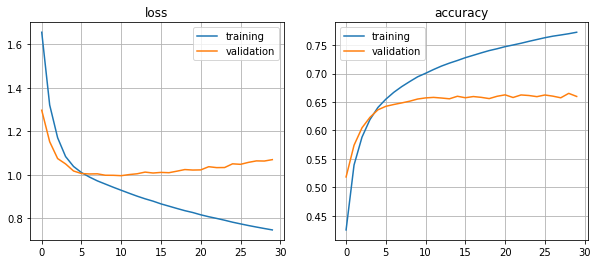

In [ ]:
plot_result(history)

We krijgen 66% nauwkeurigheid bij de validatie wat dus significant beter is dan de score van de RNN!

Laten we tot slot enkele zinnen uit de testset vertalen:

In [ ]:
import numpy as np

spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Tom can't find his keys.
[start] tom no puede encontrar sus llaves [end]
-
Dust had accumulated on the desk.
[start] el gobierno [UNK] por el escritorio [end]
-
I need a volunteer to help Tom clean the garage.
[start] necesito un desayuno que ayude a tom a tomar la [UNK] [end]
-
I'd like to speak to Tom about his brother John.
[start] me gustaría hablar con tom sobre su hermano pequeño [end]
-
There isn't much difference between the two.
[start] no hay mucha diferencia entre los dos [end]
-
I'll see you when I get back.
[start] te voy a ver cuándo volver [end]
-
Study as hard as you can.
[start] estudia tanto como puedas [end]
-
I want you where I can see you.
[start] quiero que dónde verte [end]
-
I knew you'd like that.
[start] sabía que te gustaría eso [end]
-
I wonder if they'll get divorced.
[start] me pregunto si se [UNK] [end]
-
When we are away from home, nothing gives us more pleasure than to receive a parcel from home.
[start] cuando no estamos de casa no nos estamos más qu

Ziet er niet slecht uit! En beter dan de vertalingen van de RNN! (Ook al is dat natuurlijk een subjectieve waarneming...).

### KerasNLP

In deze notebook werd de code voor de Transformer encoder en decoder zelf geschreven mbv subclassing. Ondertussen bestaat er echter ook al een Keras toolbox speciaal voor NLP: [KerasNLP](https://keras.io/api/keras_nlp/). Die bevat o.a. een `TransformerEncoder` layer, een `TransformerDecoder` layer, en een `PositionEmbedding` layer.

---